In [81]:
import numpy as np
import sympy as sym
from scipy import linalg
import json
import matplotlib.pyplot as plt
from ae483tools import *

# 3. Implement and test observer (offline)

## 3.1 Load and parse flight data

**Replace this cell** with a description of the flight trajectory, flight conditions, flight settings (e.g., what was the value of `use_controller`), etc., that produced the data `lab07_square02.json` you are using in this section.

Load flight data.

In [82]:
# Load model
with open('model.json', 'r') as f:
    model = json.load(f)

# Parse model
A = np.array(model['A'])
B = np.array(model['B'])
C = np.array(model['C'])
D = np.array(model['D'])
g = model['g']
k_flow = model['k_flow']
p_z_eq = model['p_z_eq']
r_s_eq = model['r_s_eq']

# Show model
A_str = np.array2string(A,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('A = '),
                max_line_width=np.inf)
B_str = np.array2string(B,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('B = '),
                max_line_width=np.inf)
C_str = np.array2string(C,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('C = '),
                max_line_width=np.inf)
D_str = np.array2string(D,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('D = '),
                max_line_width=np.inf)
print('STATE-SPACE MODEL')
print(f'A = {A_str}')
print(f'B = {B_str}')
print(f'C = {C_str}')
print(f'D = {D_str}')
print('PARAMETER VALUES')
print(f'g      = {g:7.4f}')
print(f'k_flow = {k_flow:7.4f}')
print(f'p_z_eq = {p_z_eq:7.4f}')
print(f'r_s_eq = {r_s_eq:7.4f}')

# Check that all numbers in model are finite (i.e., not Inf, not NaN)
assert(np.all(np.isfinite(A)))
assert(np.all(np.isfinite(B)))
assert(np.all(np.isfinite(C)))
assert(np.all(np.isfinite(D)))

STATE-SPACE MODEL
A = [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  9.8100,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -9.8100,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 

In [83]:
# Load flight data
# raw_data_drone, raw_data_mocap = load_hardware_data('calibration_default_obs_2.json')
raw_data_drone, raw_data_mocap = load_hardware_data('follower_test_moving2.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
# data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'])

# Only look at data from when the drone was actually flying
only_in_flight(data_drone)

Parse flight data. We label state estimates from the drone as `_default` to indicate that they come from the default observer.

In [84]:
# time
t = data_drone['time']

# state estimates from default observer
p_x_default = data_drone['ae483log.p_x']
p_y_default = data_drone['ae483log.p_y']
p_z_default = data_drone['ae483log.p_z']
psi_default = data_drone['ae483log.psi']
theta_default = data_drone['ae483log.theta']
phi_default = data_drone['ae483log.phi']
v_x_default = data_drone['ae483log.v_x']
v_y_default = data_drone['ae483log.v_y']
v_z_default = data_drone['ae483log.v_z']
# r_s_default = data_drone['ae483log.r_s']

Define parameter values.

In [85]:
dt = t[1] - t[0]
print(f'dt = {dt:.4f}')
assert(np.isclose(dt, 0.01))

dt = 0.0100


## 3.2 Apply observer for gain matrix chosen by equal weights

Implement and run your observer in the following code cell.

For each state, the result will be a numpy array (e.g., `p_x_offline`) that contains a state estimate at every time step. We label state estimates as `_offline` to indicate that they come from a custom observer that has been implemented offline. We also label the arrays of inputs (e.g., `w_x_offline`) and outputs (e.g., `n_x_offline`) as `_offline` to indicate that they are being used by a custom observer that has been implemented offline.

In [86]:
# Get inputs
w_x_offline = data_drone['ae483log.w_x']
w_y_offline = data_drone['ae483log.w_y']
w_z_offline = data_drone['ae483log.w_z']
a_z_offline = data_drone['ae483log.a_z']

# Get outputs
n_x_offline = data_drone['ae483log.n_x']
n_y_offline = data_drone['ae483log.n_y']
r_offline = data_drone['ae483log.r']
d_offline = data_drone['ae483log.d']

# Initialize estimates
p_x = p_x_default[0]
p_y = p_y_default[0]
p_z = p_z_default[0]
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.
p_x_t = 0.
p_y_t = 0.
p_z_t = 0.
r_s = 0.
r_s_minusone = 0.
r_s_minustwo = 0.

# Initialize storage (do not change)
p_x_offline = np.zeros(len(t))
p_y_offline = np.zeros(len(t))
p_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))
p_x_t_offline = np.zeros(len(t))
p_y_t_offline = np.zeros(len(t))
p_z_t_offline = np.zeros(len(t))
r_s_offline = np.zeros(len(t))
r_s_dot_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    n_x = n_x_offline[i]
    n_y = n_y_offline[i]
    r = r_offline[i]
    d = d_offline[i]
    
    # Compute each element of:
    #
    #  C x + D u - y
    #
    n_x_err = k_flow * (v_x / p_z_eq - w_y) - n_x
    n_y_err = k_flow * (v_y / p_z_eq + w_x) - n_y
    r_err = (p_z-p_z_eq) - (r - p_z_eq)
    d_err = r_s - d
    
    # Update estimates
    p_x += dt * v_x
    p_y += dt * v_y
    p_z += dt * (v_z - 24.182550 * r_err)
    p_x_t += dt * v_x
    p_y_t += dt * v_y
    p_z_t += dt * v_z
    # if i == 0:
    if np.abs(d) < 7.:
        r_s_minustwo = r_s_minusone
        r_s_minusone = r_s
        r_s += dt * (- d_err)
    else: 
        r_s = r_s

    # print(r_s - r_s_minusone)

    r_s_dot = (3. * r_s - 4. * r_s_minusone + r_s_minustwo) / (2. * dt)
    # r_s_dot = (r_s - r_s_minusone) / dt

    # else:
    #     r_s += dt * ((v_x * p_x_t + v_y * p_y_t + v_z * p_z_t) / r_s  - d_err)
    #     r_s += dt * ((v_x * p_x_t + v_y * p_y_t + v_z * p_z_t) / r_s  - d_err)
    psi += dt * w_z
    theta += dt * (w_y - 0.004880 * n_x_err)
    phi += dt * (w_x + 0.007771 * n_y_err)
    v_x += dt * (g * theta - 0.119176 * n_x_err)
    v_y += dt * (-g * phi - 0.149082 * n_y_err)
    v_z += dt * ((a_z - g) - 113.840826 * r_err)
    

    # L = [[    0.000000     0.000000    24.182550    -0.000000]
    #  [    0.004880    -0.000000     0.000000    -0.000000]
    #  [    0.000000    -0.007771    -0.000000    -0.000000]
    #  [    0.119176    -0.000000     0.000000    -0.000000]
    #  [   -0.000000     0.149082     0.000000     0.000000]
    #  [    0.000000     0.000000   113.840826    -0.000000]
    #  [   -0.000000     0.000000    -0.000000     1.000000]]
    
    # Store estimates (do not change)
    p_x_offline[i] = p_x
    p_y_offline[i] = p_y
    p_z_offline[i] = p_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z
    p_x_t_offline[i] = p_x_t
    p_y_t_offline[i] = p_y_t
    p_z_t_offline[i] = p_z_t
    r_s_offline[i] = r_s
    r_s_dot_offline[i] = r_s_dot

Compute error in each state estimate (relative to state estimates produced by the default observer and logged during the flight test).

In [87]:
p_x_t_w = -1.2
p_y_t_w = 1.2
p_z_t_w = 0.

p_t_w = np.array([p_x_t_w, p_y_t_w, p_z_t_w])

p_x_t_default = p_x_default - p_x_t_w
p_y_t_default = p_y_default - p_y_t_w
p_z_t_default = p_z_default - p_z_t_w

p_x_t_w_offline = p_x_offline - p_x_t_offline
p_y_t_w_offline = p_y_offline - p_y_t_offline
p_z_t_w_offline = p_z_offline - p_z_t_offline

# p_b_t_default = np.block([[p_x_t_default], [p_y_t_default], [p_z_t_default]]).T

# r_s_default = np.array([np.linalg.norm(p) for p in p_b_t_default])
# print(p_b_t_default)
# print(r_s_default)

In [88]:
p_x_err = p_x_offline - p_x_default
p_y_err = p_y_offline - p_y_default
p_z_err = p_z_offline - p_z_default
psi_err = psi_offline - psi_default
theta_err = theta_offline - theta_default
phi_err = phi_offline - phi_default
v_x_err = v_x_offline - v_x_default
v_y_err = v_y_offline - v_y_default
v_z_err = v_z_offline - v_z_default
p_x_t_err = p_x_t_offline - p_x_t_w
p_y_t_err = p_y_t_offline - p_y_t_w
p_z_t_err = p_z_t_offline - p_z_t_w
# r_s_err = r_s_offline - r_s_default

Compare estimates with those produced by (1) the default observer and (2) the motion capture system.

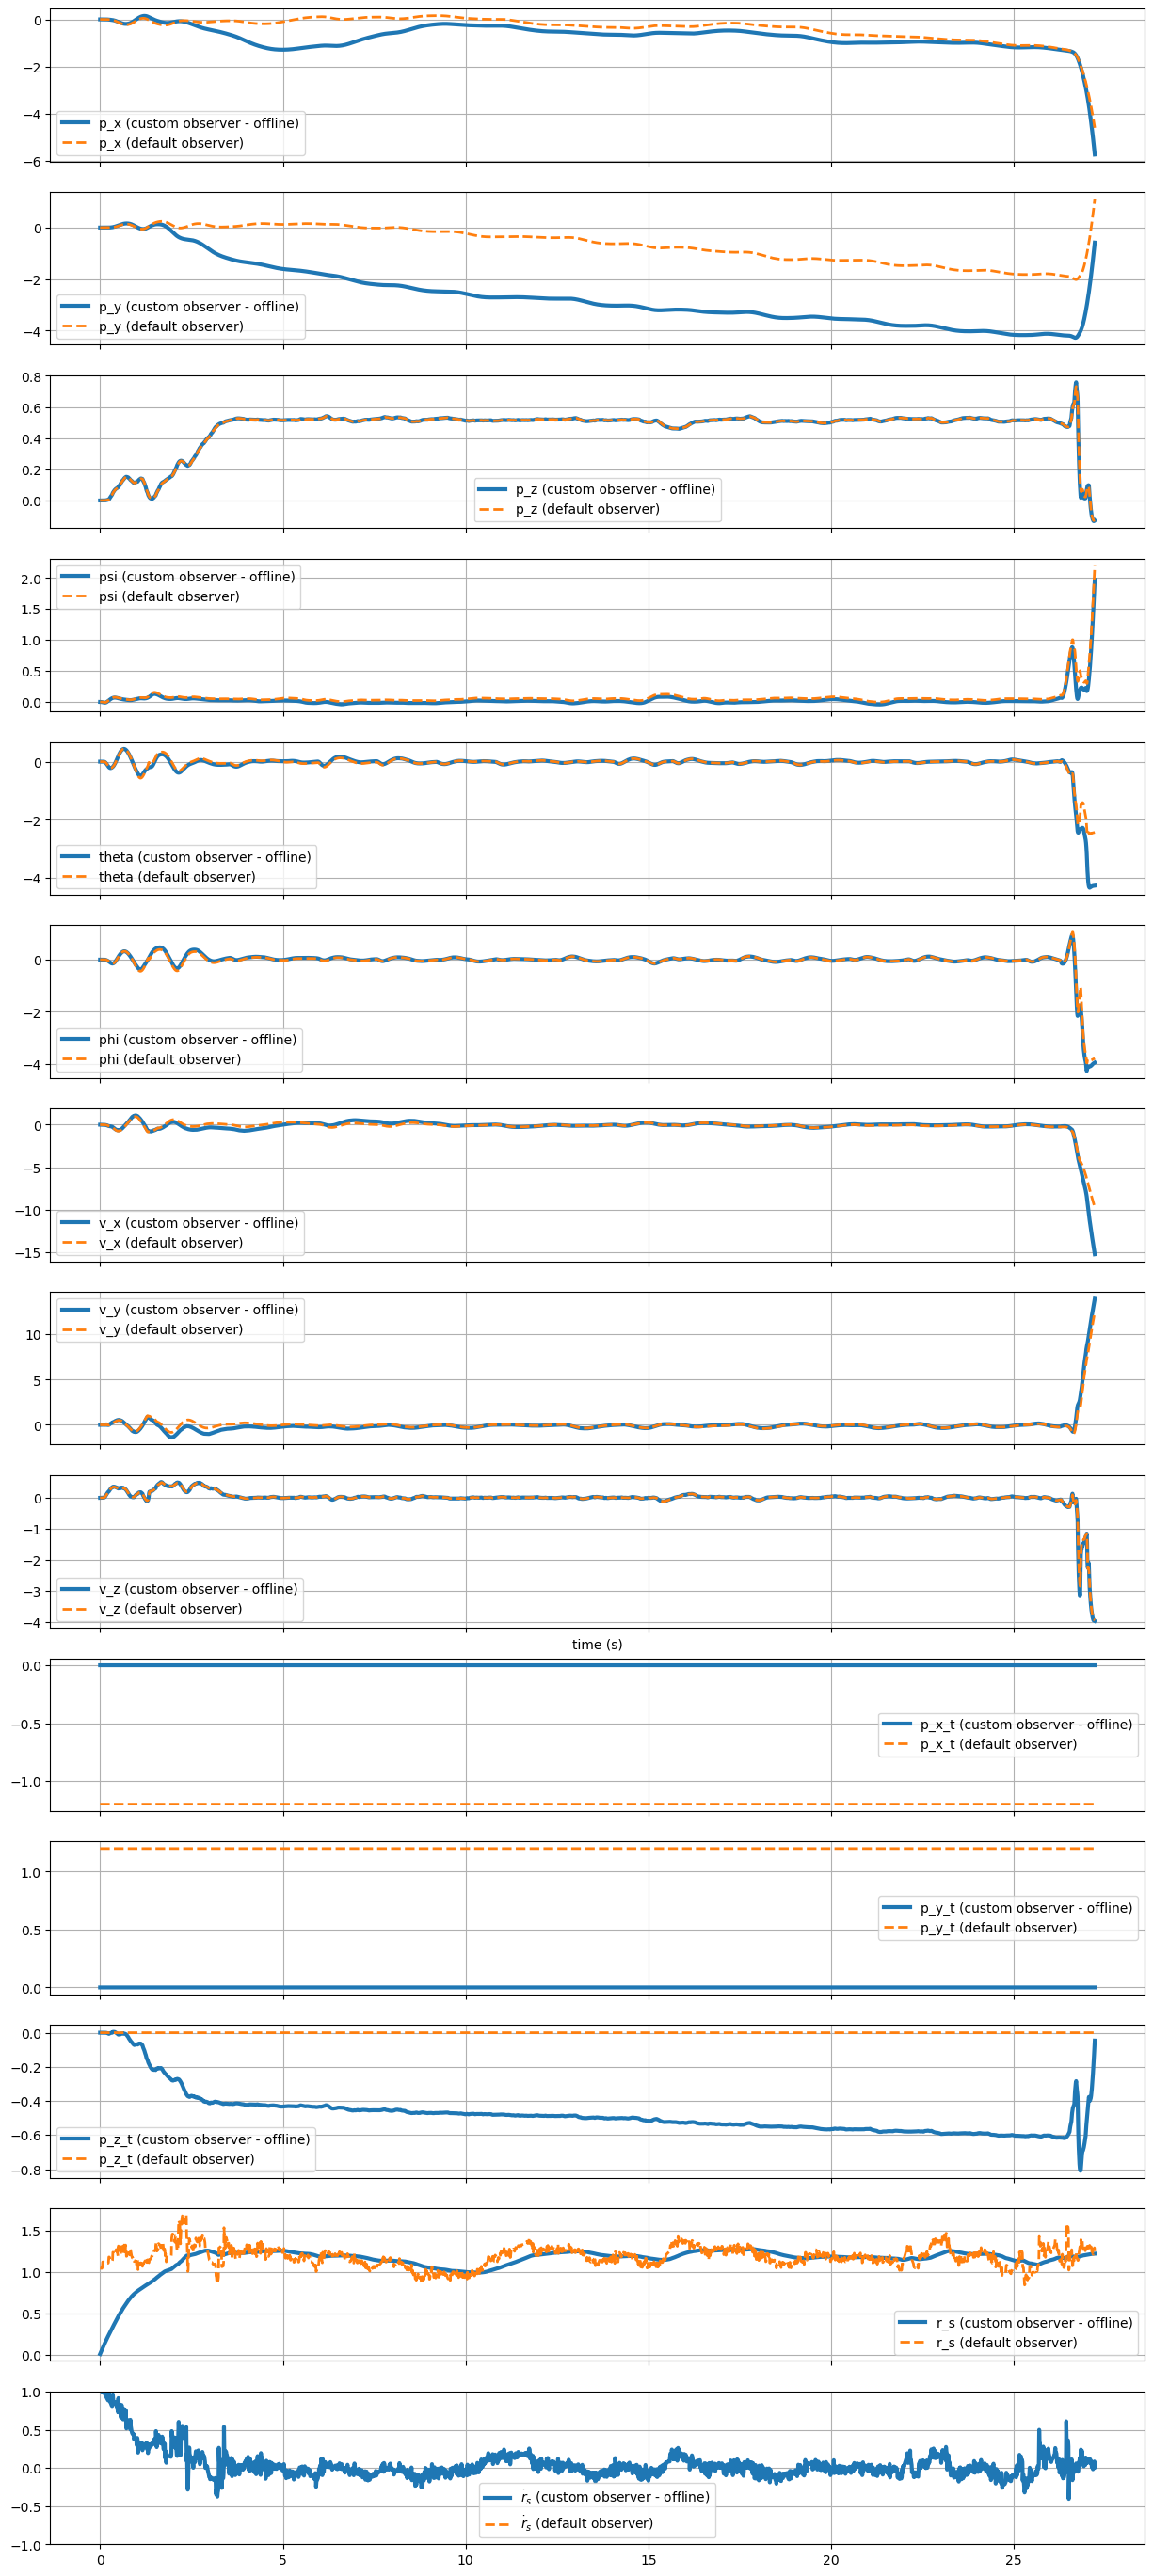

In [89]:
def comparison_plot(t, s_offline, s_default, name, ax, s_mocap=None):
    ax.plot(t, s_offline, label=f'{name} (custom observer - offline)', linewidth=3)
    ax.plot(t, s_default, '--', label=f'{name} (default observer)', linewidth=2)
    if s_mocap is not None:
        ax.plot(t, s_mocap, ':', label=f'{name} (mocap)', linewidth=4)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z,
      ax_p_x_t,
      ax_p_y_t,
      ax_p_z_t,
      ax_r_s,
      ax_r_s_dot) = plt.subplots(14, 1, figsize=(15, 35), sharex=True)
comparison_plot(t, p_x_offline, p_x_default, 'p_x', ax_p_x)
comparison_plot(t, p_y_offline, p_y_default, 'p_y', ax_p_y)
comparison_plot(t, p_z_offline, p_z_default, 'p_z', ax_p_z)
comparison_plot(t, psi_offline, psi_default, 'psi', ax_psi)
comparison_plot(t, theta_offline, theta_default, 'theta', ax_theta)
comparison_plot(t, phi_offline, phi_default, 'phi', ax_phi)
comparison_plot(t, v_x_offline, v_x_default, 'v_x', ax_v_x)
comparison_plot(t, v_y_offline, v_y_default, 'v_y', ax_v_y)
comparison_plot(t, v_z_offline, v_z_default, 'v_z', ax_v_z)
comparison_plot(t, p_x_t_w_offline, p_x_t_w * np.ones(len(t)), 'p_x_t', ax_p_x_t)
comparison_plot(t, p_y_t_w_offline, p_y_t_w * np.ones(len(t)), 'p_y_t', ax_p_y_t)
comparison_plot(t, p_z_t_w_offline, p_z_t_w * np.ones(len(t)), 'p_z_t', ax_p_z_t)
comparison_plot(t, r_s_offline, d_offline, 'r_s', ax_r_s)
comparison_plot(t, r_s_dot_offline, np.ones(len(t)), r'$\dot{r}_s$', ax_r_s_dot)
ax_v_z.set_xlabel('time (s)')

# ax_r_s.set_ylim([-5., 5.])
ax_r_s_dot.set_ylim([-1., 1.])

plt.show()

Plot error in each state estimate with respect to ground truth.

In [93]:
np.sqrt(np.mean((r_s_offline[1000:] - 0.8) ** 2))

np.float64(0.3874216748656583)